# Comparaison des différentes variantes d'Adaboost pour la prédiction de séries temporelles

## Introduction

*Adaboost* est un algorithme ensembliste très populaire pour la classification en machine learning qui a aussi été étendu à la prédiction de données temporelles. 

Pourtant, malgré son succès, les performances d'*Adaboost* et de ses variantes pour la prédiction n'ont jamais été évalué de manière rigoureuse sur un ensemble de données empiriques représentatif.

Le but de cette étude est donc de comparer les différentes implémentations d'AdaBoost sur le jeu de données NN3 composé de 111 séries temporelles provenant de l'industrie.

## I. La prédiction de séries temporelles

La problématique à laquelle nos algorithmes de type Adaboost vont pouvoir répondre est celle des prédictions de séries temporelles.

Une série temporelle est une séquence de valeurs numériques indexées dans le temps avec, idéalement, un pas de temps identiques entre deux observations successives. 
Voyons la représentation graphique de 6 séries temporelles provenant de notre jeu de données NN3 utilisé :

In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [8]:
df = pd.read_csv("NN3_FINAL_DATASET_WITH_TEST_DATA .CSV")

In [100]:
# Fonction pour afficher des séries temporelles en fonction de l'ID
def get_ts(id):
    to_rm = ['NN3 Time Series #ID','Original M3 Time Series','Start Year','Start Month','Months per Year','Dataset']
    ts = df[df['NN3 Time Series #ID'] == id]
    for key in to_rm:
        del ts[key]
    ts = np.array(ts.dropna(axis=1))[0]
    return ts
    
def plot_ids(ids, test = False, preds = False):
    n = len(ids)
    plt.figure("Time series from NN3",figsize=(20,3*(n+2)//3))
    count = 1
    for id in ids:
        ts = get_ts(id)
        plt.subplot((n+2)//3,3,count)
        plt.title(id)
        plt.plot(ts)
        if test:
            t = list(range(len(ts)))
            plt.plot(t[-18:],ts[-18:],'r')
        if preds:
            t = list(range(len(ts)))
            plt.plot(t[-18:],preds[count-1],'g')
        count+=1
    

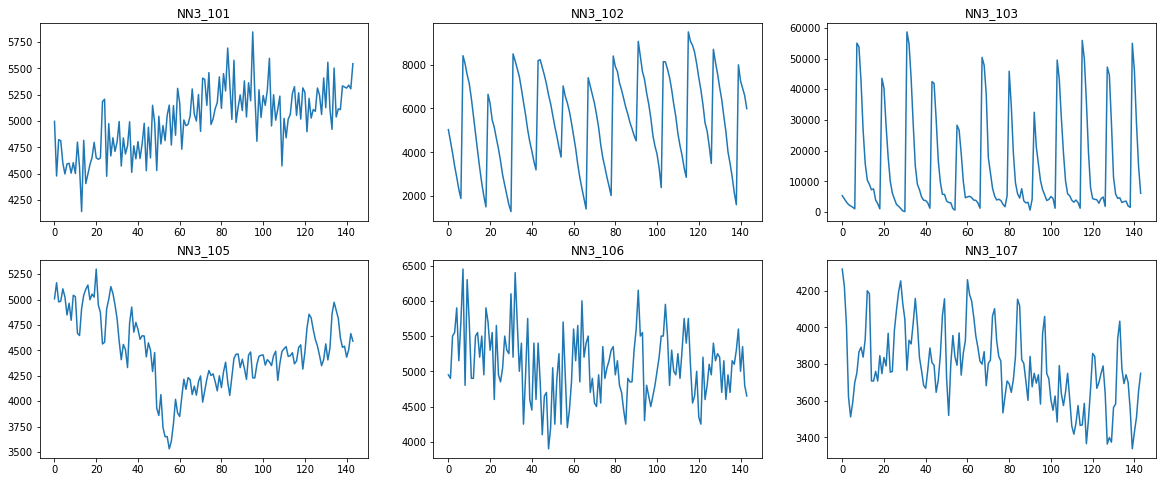

In [13]:
plot_ids(['NN3_101','NN3_102','NN3_103','NN3_105','NN3_106','NN3_107'])

La prédiction de séries temporelles consiste alors, en connaissant les valeurs de la série jusqu'à n'importe quel temps *t*, à prévoir les valeurs suivantes le plus précisément possible.
Par exemple, pour la compétition NN3 utilisant ce dataset, il fallait en connaissant les données présentées en bleues ci-dessous être capable de prévoir les 18 données suivantes en rouge.

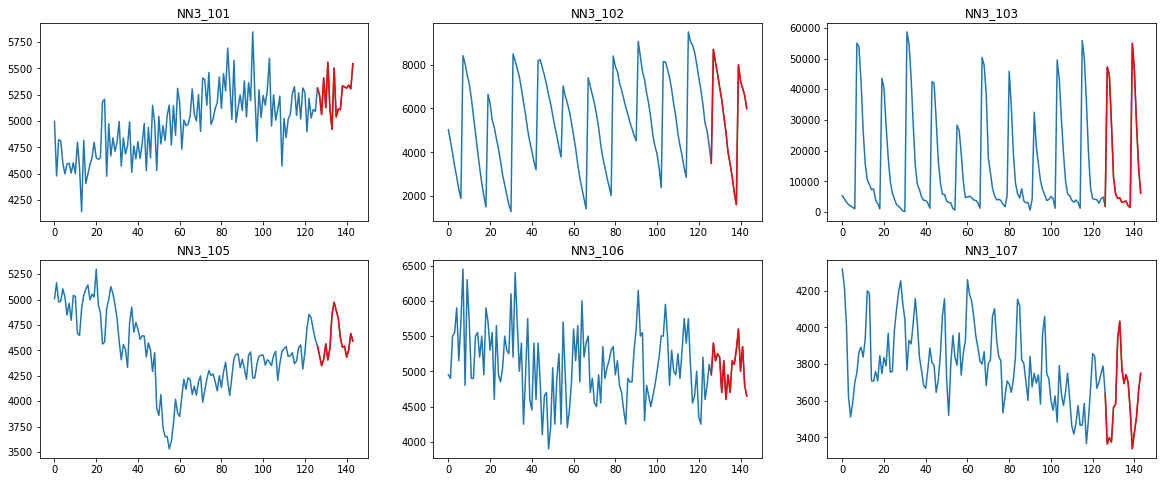

In [15]:
examples = ['NN3_101','NN3_102','NN3_103','NN3_105','NN3_106','NN3_107']
plot_ids(examples, test=True)

Le dataset utilisé est bien équilibré puiqu'il est composé de 50 séries longues, 50 séries courtes avec 50 séries saisonnales et 50 séries non saisonnales et les dernières 11 séries qui montrent des patterns plus complexes. 
Ainsi, en évaluant les méthodes de prédiction sur ce dataset, on obtient une performance assez représentative de la méthode en général.

## II. Idée générale d'Adaboost

*Adaboost* est un algorithme de machine learning très populaire qui utilise la méthode du *Boosting*. 

Le principe général du *Boosting* consiste à construire une famille d'estimateurs dit "faibles" qui sont ensuite combinés par une moyenne (ou autre méthode) pondérée des estimations pour obtenir un estimateur "fort".
Les estimateurs sont construits de manière récursive : chaque estimateur est une version adaptative du précédent où l'on donne plus de poids aux observations les plus mal prédites. L’estimateur construit à l’étape k concentrera donc ses efforts sur les observations mal prédites par l’estimateur à l’étape k−1.

En général, on choisit souvent comme estimateur "faible" de base des arbres de régression ou des MLPs à "booster" pour devenir un estimateur "fort".

Regardons plus précisément le fonctionnement de l'algorithme de boosting *Adaboost* appliqué à la régression:

<div class="alert alert-success">
Soit $\left\{\left(x_i,y_i\right)\right\}, x_i \in X, y_i \in \mathbb{R}$ (les données à prédire) et $\mathcal{H}$ l'ensemble des estimateurs faibles de base <br>
Initialisation des poids $w_1(i) = \frac{1}{q}$<br>
    For $t=1$ to $T$ <em> (à préciser) </em>:
<ul>
<li> Trouver $h_t = \arg\min\limits_{h\in\mathcal{H}} \sum\limits_{i=1}^q w_t(i) L(y_i,h(x_i))$ <em> avec L une loss fonction à préciser </em>
<li> If $L_t = \sum\limits_{i=1}^q w_t(i) L(y_i,h_t(x_i)) \geq 1/2$ then stop <em> (un critère d'arrêt) </em>
<li> $\alpha_t = \log\left(\frac{1-L_t}{L_t}\right)$ <em> le poids de l'estimateur en lien avec le critère d'arrêt </em>
<li> Mettre à jour les poids
$$w_{t+1}(i) = \frac{w_t(i) e^{\alpha_t(1 - L(y_i,h_t(x_i)))}}{Z_t}$$
Où $Z_t$ est un facteur de normalisation.
</ul>

Retourner l'estimateur avec une combination des estimateurs (moyenne ou médiane / pondérée ou simple)
$$H(x) = \sum\limits_{t=1}^T \alpha_t h_t(x)$$
</div>

### Une première application d'Adaboost

Pour avoir une première idée du fonctionnement d'AdaBoost, implémentons cet algorithme dans sa première version la plus simple *(Drucker, 1997)* en utilisant des arbres de régression comme estimateur de base.
Dans cette version, la *Loss* fonction choisie est alors:
$ L(y_i,h(x_i)) = |h(x_i) - y_i|/D$ où $D = sup_i(|h(x_i) - y_i|)$ est l'erreur maximale sur tous les $(x_i,y_i)$ :


Tout d'abord, pour pouvoir appliquer des algortihmes d'apprentissage supervisé on transforme nos séries temporelles en dataset $X,y$ avec $X$ les $n$ valeurs des $n$ pas de temps précédent le pas de temps à prédire $y$ avec $n$ la valeur de la fenêtre. 

In [35]:
def convert_ts(ts,window = 6):
    X = []
    y = []
    for i in range(len(ts)-window):
        X.append(ts[i:i+window])
        y.append(ts[i+window])
    return np.array(X),np.array(y)

Pour comparer les performances entre les différentes méthodes on utilise la SMAPE (symmetric mean absolute
percent error) définie pour une série temporelle par :
$SMAPE = \frac{1}{n} \sum\limits_{t=1}^n \frac{|Y_t - F_t|}{(|Y_t| + |F_t|)/2} 100$
avec $Y_t$ les vraies valeurs, $F_t$ les valeurs prédites et $n$ le nombres d'observations.


In [16]:
def smape(y_true,y_pred):
    s = 0
    for i in range(len(y)):
        s += np.abs(y_true[i] - y_pred[i]) / (np.abs(y_true[i]) + np.abs(y_pred[i])) * 200
    return s

On peut alors implémenter la fonction mettant en oeuvre Adaboost pour retourner les prédictions souhaitées.

In [28]:
from sklearn.tree import DecisionTreeRegressor

In [109]:
def adaboost_forecast_one_step(X_train,y_train,X_pred):
    N = 50
    forest = list()
    sample_weights = np.ones(len(y_train))/len(y_train)
    tree_weights = np.zeros(N)
    for i in range(N):
        # Train tree
        dt = DecisionTreeRegressor(max_depth=5)
        dt.fit(X_train,y_train,sample_weight=sample_weights)
        # Compute error
        y_pred = dt.predict(X_train)
        reg_loss = sum(np.abs(y_pred - y_train)*sample_weights) / (sum(sample_weights)*max(np.abs(y_pred - y_train)))
        forest.append(dt)
        # Get tree weight
        alpha = np.log((1-reg_loss)/reg_loss)
        tree_weights[i] = alpha
        # Update weights
        sample_weights = sample_weights*np.exp(alpha*(1-np.abs(y_pred - y_train)*sample_weights) / (sum(sample_weights)*max(np.abs(y_pred - y_train))))
        sample_weights = sample_weights/sum(sample_weights)
    y_pred = np.zeros((X_pred.shape[0]))
    for i in range(N):
        y_pred += tree_weights[i]*forest[i].predict(X_pred)/sum(tree_weights)
    return y_pred

Affichons les prédictions sur un pas de temps en avant d'Adaboost:

In [105]:
preds= []
for id in examples:
    ts = get_ts(id)
    ts_train = ts[:-18]
    ts_test = ts[-24:]
    X_train, y_train = convert_ts(ts_train)
    X_test, y_test = convert_ts(ts_test)
    pred = adaboost_forecast(X_train,y_train,X_test)
    preds.append(pred)


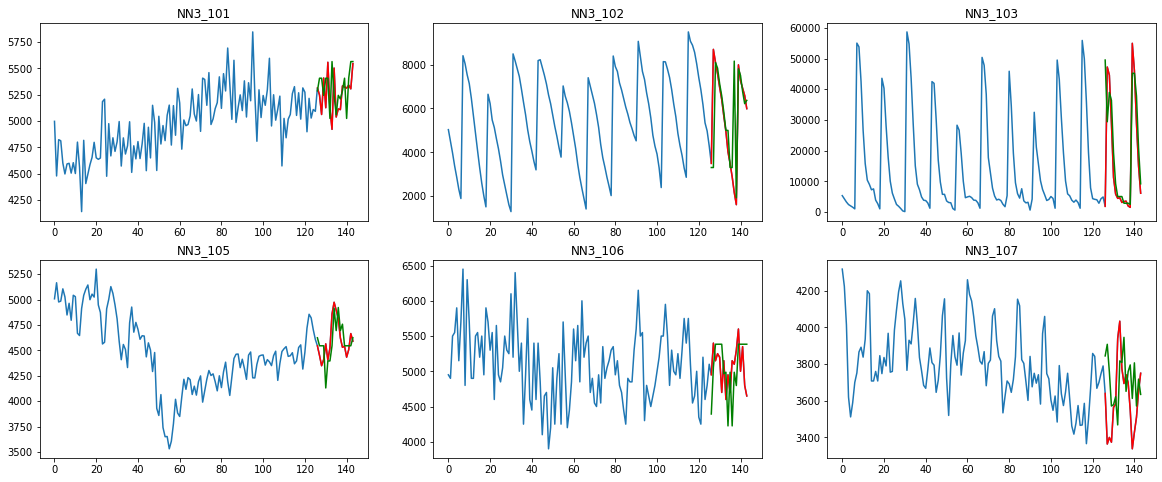

In [106]:
plot_ids(examples,test=True,preds=preds)

On peut voir qu'Adaboost permet une prédiction (en vert) plus ou moins bonne en fonction de la régularité des données pour un pas de temps après. 

Cependant, pour prédire les données en rouge sans en avoir connaissance il faut pouvoir prédire 18 pas de temps aprés. Pour cela, on va donc prévoir un pas de temps par un pas de temps en utilisant la prédiction obtenue au temps précédent comme la vraie valeur. 

In [127]:
def adaboost_forecast(id):
    y_pred = []
    ts = get_ts(id)
    ts_train = ts[:-18]
    to_pred = ts_train[np.newaxis,-6:]
    for i in range(18):
        X_train, y_train = convert_ts(ts_train)
        one_pred = adaboost_forecast_one_step(X_train,y_train,to_pred)[0]
        y_pred.append(one_pred)
        to_pred = np.roll(to_pred,-1)
        to_pred[0,-1] = one_pred
    return y_pred
    
    

In [132]:
preds= []
for id in examples:
    pred = adaboost_forecast(id)
    preds.append(pred)

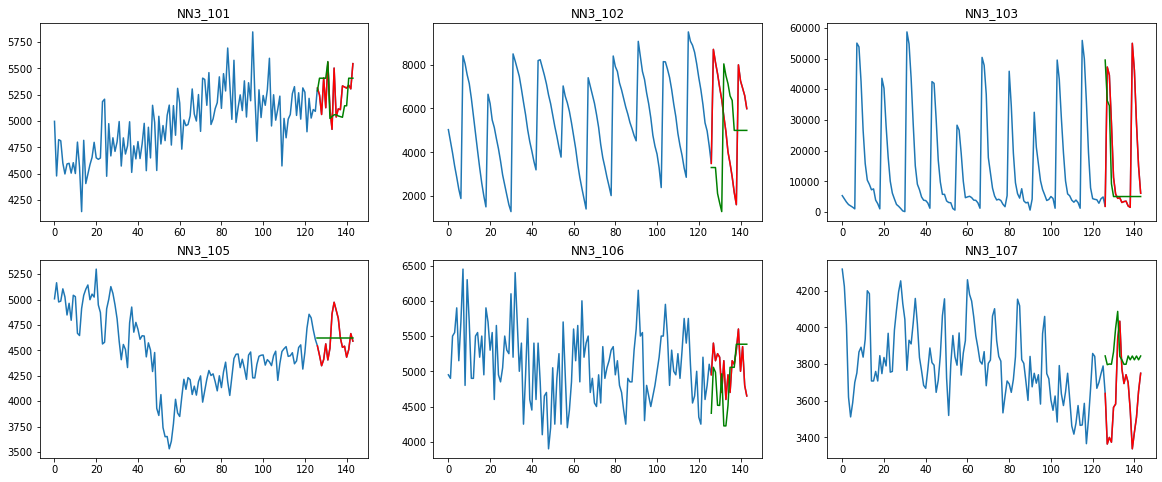

In [133]:
plot_ids(examples,test=True,preds=preds)

On a ainsi obtenu les prédiction des données rouges pour chaque séries temporelles pour lesquelles on peut calculer la SMAPE. On peut ensuite en faire la moyenne sur toutes les séries pour obtenir la performance de l'algorithme. 

## III. Adaboost et ses variantes

On a pu voir dans la partie précédente que l'algorithme Adaboost disposait de nombreux méta-paramètres que l'on peut modifier pour essayer d'améliorer les performances de l'algorithme. On peut compter au moins 6 méta-paramètres pour Adaboost:
    1. La fonction loss
Dans notre application on a choisi une fonction loss linéaire mais on aurait pu prendre une fonction loss quadratique ou exponentielle. De plus, on a pris une fonction à pourcentage mais on aurait pu prendre une fonction avec seuil qui compte une perte de 0 si l'erreur relative est en dessous d'un seuil et 1 sinon.
          
    2. La combinaison des estimateurs
La combinaison des estimateurs peut aussi être modifiée. Dans notre cas, on a utilisé une moyenne pondérée des estimations ce qui est le plus commun mais on peut aussi prendre la médiane des estimations pondérées ou la moyenne et la médiane toute simple.
    
    3. Les poids des estimateurs
Pour le poids des estimateurs, on a utilisé une fonction "bounded" où la loss $L<0.5$ mais des variantes avec des poids égaux à $log(1/L_i)$ sont aussi possibles.

    4. Le nombre d'estimateurs
Le nombre des estimateurs, ici fixé à 50 peut rester fixe ou être choisi par une méthode de cross-validation.

    5. Le calcul de la loss
On a calculé la loss en utilisant l'estimateur de l'itération *k* mais la loss peut se calculer directement en utilisant la combinaison des estimateurs à l'itération *k*.

    6. Le choix de l'estimateur de base
Enfin, le choix de l'estimateur de base, dans notre cas les arbres de régression, n'est pas un méta-paramètre propre à l'algorithme mais on peut utiliser aussi bien des MLP comme c'est aussi le cas dans l'étude.
    

## IV. Comparaison des différentes variantes

Si on liste toutes les variantes possibles d'Adaboost, on en dénombre au moins 96 sans compter le choix de l'estimateur de base alors que seulement quelques unes ont déjà été étudié dans des articles de recherche. 

On peut alors analyser quelle variante est la plus performante en calculant la SMAPE moyenne de chaque variante sur le dataset NN3. C'est ce qui est réalisé dans l'étude qui teste chaque combinaison de méta-paramètres:

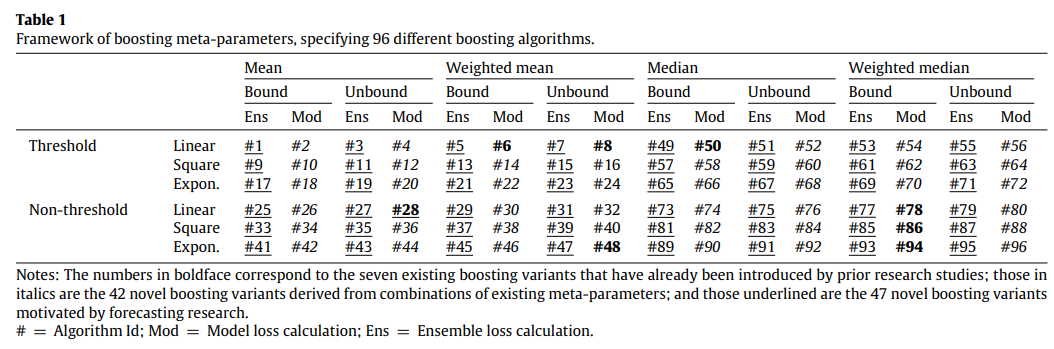

On obtient alors les résultats des différentes variantes sous la forme du tableau suivant en gardant que les paramètres significatifs:

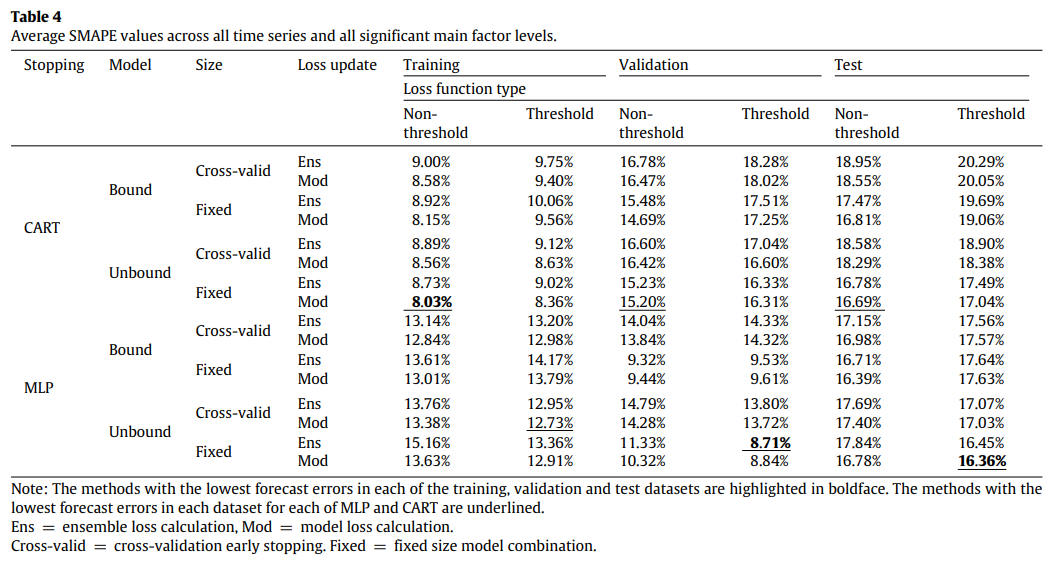

Ainsi, ces résultats nous permettent de classer les différentes variantes en fonction de leurs performances sur le dataset utilisé et de voir quel paramètre est préférable sur un autre pour la prédiction de séries temporelles.

Par exemple, on remarque qu'en choisissant un MLP comme estimateur de base on obtient de meilleurs résultats qu'avec les arbres de régressions. Aussi, un nombre d'estimateurs choisi en utilisant la cross validation donnent de moins bons résultats qu'en gardant un nombre d'estimateurs de base fixe. Enfin, on peut voir qu'en utilisant des modèles où la fonction loss moyenne est "unbounded" (où L peut dépasser 0,5) on peut aussi améliorer les performances.

Finalement, on peut déterminer la meilleur combinaison de paramètres pour l'algorithme Adaboost sur le dataset NN3. C'est l'algorithme avec une taille fixe d'estimateurs, "unbounded" et une fonction de loss avec un seuil calculé sur un estimateur et un MLP comme estimateur de base. On peut noter aussi que la même combinaison de paramètre avec une fonction loss sans seuil est deuxième dans le classement.

### Comparaison à d'autres algorithmes utilisés sur le dataset NN3

En comparant les performances de la meilleure combinaison Adaboost trouvé, on remarque que très peu d'algorithmes de machine learning le surpasse puisqu'il est à moins d'1% du meilleur algorithme de la compétition sur le dataset NN3. 
Cependant, on peut voir qu'il est très légèrement inférieur à du Bagging simple avec des MLP.

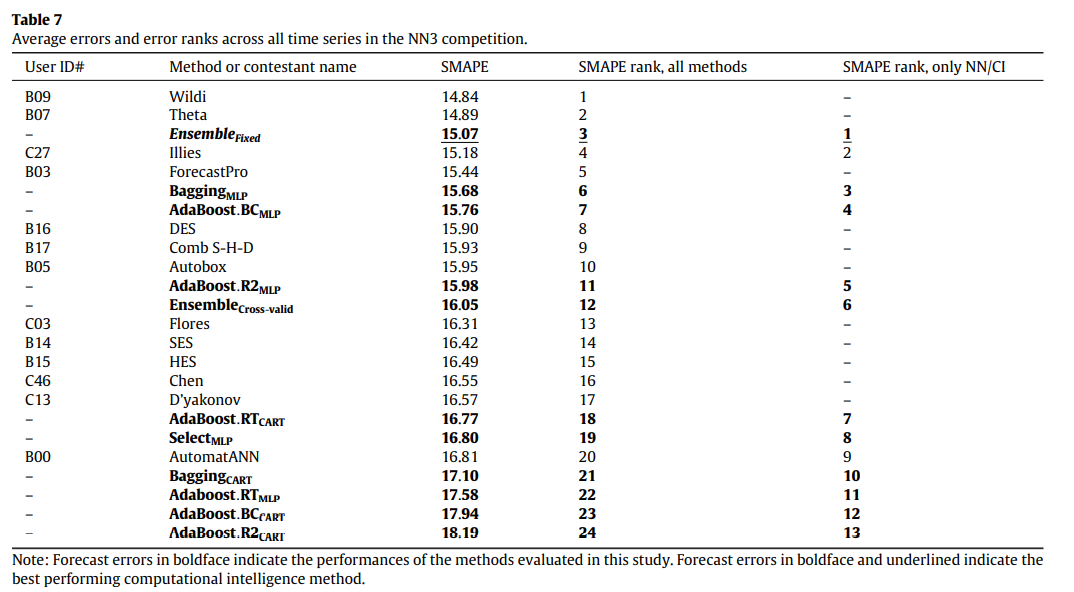

## V. Conclusion

Ainsi, on a pu voir que l'algorithme Adaboost peut être très bien adapté pour réaliser des prédictions sur des séries temporelles. Les choix de méta-paramètres standars peuvent parfois amener à une solution sous optimal mais une recherche des meilleurs paramètres à utiliser peut faire d'Adaboost un algorithme très performant qui peut concurrencer avec les meilleurs algorithmes utilisés dans le domaine de prédiction de séries temporelles.

Cependant, les nombreuses possibilités d'Adaboost fait qu'il peut-être long à optimiser ce qui peut nous pousser à nous tourner faire des méthodes moins compliquées et tout aussi performantes tel le *Bagging*.